In [1]:
import sys
import os

import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
%matplotlib inline
from tqdm import tqdm_notebook

PARENT_DIR = os.path.realpath('..')
import importlib
if PARENT_DIR not in sys.path:
    sys.path.append(PARENT_DIR)

try: importlib.reload(sl)
except: import synt_lib as sl

In [2]:
DIRS = sl.get_dirs(parent_dir=PARENT_DIR)
M_PARAMS = sl.get_model_params()

In [3]:
quant = M_PARAMS['QUANTIZATION_CHANNELS']
nbits = int(np.log2(quant))

# Build model

In [5]:
def train_model(model_class,input_dimensions, hidden_size, batch_size, truncated_len, num_epochs, model_name,
print_period=50, save_period=50, log_period=50, n_files_per_epoch=5, sparsify_epochs = [], sparsity_level=1, wav_fnames=None, align_fnames=None):
    if model_name not in os.listdir(DIRS['MODELS']):
        os.mkdir(DIRS['MODELS']+model_name)
    
    tf.reset_default_graph()
    model = model_class(input_dimensions, hidden_size)
    init_variables = tf.global_variables_initializer()
    saver = tf.train.Saver()
    if wav_fnames is None:
        wav_fnames = Path(DIRS['RAW_DATA']).rglob("*.wav")
    
    epochs_per_files_last = 0
    
    # Initialize the losses
    train_losses = []
    validation_losses = []

    with tf.Session() as sess:
        sess.run(init_variables)
        # Perform all the iterations
        for epoch in tqdm_notebook(range(num_epochs)):
            if epochs_per_files_last==0:
                X = sl.load_data(wav_fnames, n_files_per_epoch)
                if align_fnames is not None:
                    toh = sl.load_text_oh(align_fnames, n_files_per_epoch)
                total_series_length = int(X.shape[1])
                epochs_per_files_last = total_series_length//batch_size//truncated_len
            epochs_per_files_last-=1
            
            if epoch in sparsify_epochs:
                k = model.calc_sparsity_level(epoch, sparsify_epochs, sparsity_level)
                model.sparsify(k, sess)
            
            X_train, Y_train, X_test, Y_test = sl.get_train_test(X, batch_size, truncated_len, sess, text_oh=toh)
            train_loss, validation_loss = model.train(X_train, Y_train, X_test, Y_test, sess)

            # Log the losses
            train_losses.append(train_loss)
            validation_losses.append(validation_loss)
            
            msg = f'Iteration: {epoch}, train loss: {train_loss:.4f}, val loss: {validation_loss:.4f}'
            # Display an update every 50 iterations
            if epoch % print_period == 0 and epoch!=0:
                print(msg)
            if epoch % print_period == 0 and epoch!=0:
                sl.plot_losses(train_losses, validation_losses, title=msg)
                plt.show()
            if epoch % save_period == 0:
                saver.save(sess, DIRS['MODELS']+model_name+'/checkpoint',global_step=epoch,write_meta_graph=True)
        
        sl.plot_losses(train_losses, validation_losses, title=msg)
        plt.show()

        saver.save(sess, DIRS['MODELS']+model_name+'/final')
        
    return train_losses, validation_losses, model

# Get Data

Всего файлов:
* Обучение (cv-valid-train): 391552
* cv-valid-dev: 8152
* cv-valid-test: 7990

# Develop models

## Structured Sparse

In [9]:
class WaveGRU_structured_sparse:
    """Implementation of a Gated Recurrent Unit (GRU) as described in [1].
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64, variables_values_dict=None, block_shape=(16,1)):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        self.block_shape = block_shape
        
        self.define_constants()
        if variables_values_dict is None:
            self.define_variables(dtype)
        else:
            self.restore_variables(variables_values_dict)
        self.define_arithmetics()
        self.define_train_variables()
    
    def define_constants(self):
        # Mask for masking W matrixes
        M = np.ones(shape=(self.input_dimensions, self.hidden_size))
        M[2,:self.hidden_size//2]=0
        self.M = tf.constant(shape=(self.input_dimensions, self.hidden_size), value=M)
        
        m1,m2 = self.block_shape
        self.M_Ir, self.M_Iu, self.M_Ie = [np.ones(shape=(self.input_dimensions, self.hidden_size)) for i in range(3)]
        self.M_Rr, self.M_Ru, self.M_Re = [np.ones(shape=(self.hidden_size//m1, self.hidden_size//m2)) for i in range(3)]
        self.M_O1, self.M_O2, self.M_O3, self.M_O4 = [np.ones(shape=(self.hidden_size//2//m1, self.hidden_size//2//m2)) for i in range(4)]
                
        
    def define_variables(self, dtype):     
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Ir = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Ir')
        self.Iu = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Iu')
        self.Ie = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Ie')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Rr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Rr')
        self.Ru = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ru')
        self.Re = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Re')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='br')
        self.bu = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bu')
        self.be = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='be')
        
        # O's matrices
        self.O1 = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2,self.hidden_size//2), mean=0, stddev=0.01), name='O1')
        self.O3 = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2,self.hidden_size//2), mean=0, stddev=0.01), name='O3')
        self.O2 = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2,self.hidden_size//2), mean=0, stddev=0.01), name='O2')
        self.O4 = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size//2,self.hidden_size//2), mean=0, stddev=0.01), name='O4')
    
    def restore_variables(self, variables):
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Ir = tf.Variable(variables['Ir:0'], name='Ir')
        self.Iu = tf.Variable(variables['Iu:0'], name='Iu')
        self.Ie = tf.Variable(variables['Ie:0'], name='Ie')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Rr = tf.Variable(variables['Rr:0'], name='Rr')
        self.Ru = tf.Variable(variables['Ru:0'], name='Ru')
        self.Re = tf.Variable(variables['Re:0'], name='Re')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(variables['br:0'], name='br')
        self.bu = tf.Variable(variables['bu:0'], name='bu')
        self.be = tf.Variable(variables['be:0'], name='be')
        
        # O's matrices
        self.O1 = tf.Variable(variables['O1:0'], name='O1')
        self.O3 = tf.Variable(variables['O2:0'], name='O3')
        self.O2 = tf.Variable(variables['O3:0'], name='O2')
        self.O4 = tf.Variable(variables['O4:0'], name='O4')
    
    def define_arithmetics(self):
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, self.input_dimensions), name='input')
        #[c_t-1, f_t-1, c_t]
        
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        #[f_t-1, c_t-1, c_t]
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(self.input_dimensions, self.hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        self.y_c, self.y_f = tf.split(self.h_t_transposed, num_or_size_splits=2, axis=2, name='split_y')
        # Transpose the result back
        #self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')
        
        self.P_ct = tf.scan(self.get_P_cs, self.y_c, name='calc_Pc')
        self.c_t_transposed = tf.reduce_max(self.P_ct, axis=2, name='c_t_trans')
        self.c_t = tf.transpose(self.c_t_transposed, name='c_t')
        self.P_ft = tf.scan(self.get_P_fs, self.y_f, name='calc_Pf')
        self.f_t_transposed = tf.reduce_max(self.P_ft, axis=2, name='f_t_trans')
        self.f_t = tf.transpose(self.f_t_transposed, name='f_t')
        
        self.y = tf.stack([self.c_t, self.f_t], axis=2, name='y')
    
    def define_train_variables(self):
        self.output = self.y
        self.expected_output = tf.placeholder(
            dtype=tf.float64, shape=(None, None, 2), name='expected_output'
            #(batch_size, truncated_len, 2), name='expected_output'
        )
        #self.loss = tf.reduce_sum(0.5 * tf.pow(self.output - self.expected_output, 2)) / float(batch_size)
        # mean(1/2 * (y-y_true)^2)
        self.loss = tf.reduce_mean(0.5 * tf.pow(self.output - self.expected_output, 2), name='loss')
        self.train_step = tf.train.AdamOptimizer().minimize(self.loss)
        
    def get_P_cs(self, lastP, y_c):
        M_O1, M_O2 = [self.extend_matrix(M) for M in [self.M_O1, self.M_O2]]
        O1_sparse, O2_sparse = tf.multiply(self.O1, M_O1, name='O1_sparse'), tf.multiply(self.O2, M_O2, name='O2_sparse')
        return tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(y_c, O1_sparse)), O2_sparse), axis=1, name='P_c')
    def get_P_fs(self, lastP, y_f):
        M_O3, M_O4 = [self.extend_matrix(M) for M in [self.M_O3, self.M_O4]]
        O3_sparse, O4_sparse = tf.multiply(self.O3, M_O3, name='O3_sparse'), tf.multiply(self.O4, M_O4, name='O4_sparse')
        return tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(y_f, O3_sparse)), O4_sparse), axis=1, name='P_f')
        
    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        self.Iu_masked = tf.multiply(self.Iu, self.M, name='Iu_mask')
        self.Ir_masked = tf.multiply(self.Ir, self.M, name='Ir_mask')
        self.Ie_masked = tf.multiply(self.Ie, self.M, name='Ie_mask')
                      
        #M_Iu, M_Ir, M_Ie = [self.extend_matrix(M) for M in [self.M_Iu, self.M_Ir, self.M_Ie]]
        M_Ru, M_Rr, M_Re = [self.extend_matrix(M) for M in [self.M_Ru, self.M_Rr, self.M_Re]]
                
        #self.Iu_sparse = tf.multiply(self.Iu_masked, M_Iu, name='Iu_sparse')
        #self.Ir_sparse = tf.multiply(self.Ir_masked, M_Ir, name='Ir_sparse')
        #self.Ie_sparse = tf.multiply(self.Ie_masked, M_Ie, name='Ie_sparse')
        self.Iu_sparse, self.Ir_sparse, self.Ie_sparse = self.Iu_masked, self.Ir_masked, self.Ie_masked
        self.Ru_sparse = tf.multiply(self.Ru, M_Ru, name='Ru_sparse')
        self.Rr_sparse = tf.multiply(self.Rr, M_Rr, name='Rr_sparse')
        self.Re_sparse = tf.multiply(self.Re, M_Re, name='Re_sparse')
        
        
        # Definitions of z_t and r_t
        u_t = tf.sigmoid(tf.matmul(h_tm1, self.Ru_sparse) + tf.matmul(x_t, self.Iu_sparse) + self.bu, name='u_t')
        r_t = tf.sigmoid(tf.matmul(h_tm1, self.Rr_sparse) + tf.matmul(x_t, self.Ir_sparse) + self.br, name='r_t')
        # Definition of h~_t
        e_t = tf.tanh(tf.multiply(r_t, tf.matmul(h_tm1, self.Re_sparse))+tf.matmul(x_t, self.Ir_sparse)+ self.be, name='e_t')
        # Compute the next hidden state
        h_t = tf.multiply(u_t, h_tm1) + tf.multiply(1 - u_t, e_t)
        return h_t
    
    def get_sparse_matrix(self, tensor, k, session):
        tensor_ev = tensor.eval(session=session)
        m1,m2 = self.block_shape
        shorted = np.array([[tensor_ev[m1*i:m1*(i+1),m2*j:m2*(j+1)].mean() for j in range(tensor_ev.shape[1]//m2)] for i in range(tensor_ev.shape[0]//m1)])
        flat = shorted.flatten()
        k_ = int(k*int(flat.shape[0]))
        idxs = flat.argsort()[:k_]
        M = np.ones((int(flat.shape[0])))
        M[idxs] = 0
        return M.reshape(shorted.shape)
        
        #flat = tf.reshape(tensor, (-1,))
        #k_ = int(k*int(flat.shape[0]))
        #idxs = session.run(tf.math.top_k(-flat, k_).indices)
        #M = np.ones((int(flat.shape[0])))
        #M[idxs] = 0
        #return M.reshape(tensor.shape)
    
    def sparsify(self, k, session):
        #self.M_Iu, self.M_Ir, self.M_Ie = [
        #    self.get_sparse_matrix(t, k, session) for t in [self.Iu, self.Ir, self.Ie]]
        self.M_Ru, self.M_Rr, self.M_Re = [
            self.get_sparse_matrix(t, k, session) for t in [self.Ru, self.Rr, self.Re]]
        self.M_O1, self.M_O2, self.M_O3, self.M_O4 = [
            self.get_sparse_matrix(t, k, session) for t in [self.O1, self.O2, self.O3, self.O4]]
            #self.get_sparse_matrix(t, k, session) for t in [self.M_O1, self.M_O2, self.M_O3, self.M_O4]]

    def extend_matrix(self, M):
        coefs = self.block_shape
        return np.concatenate([[np.concatenate([[j]*coefs[1] for j in i])]*coefs[0] for i in M])                
        
    @staticmethod
    def calc_sparsity_level(t,sparsify_epochs ,sparsity_level):
        t0 = min(sparsify_epochs)
        S = max(sparsify_epochs)-t0
        Z = sparsity_level
        return Z*(1-(1-(t-t0)/S)**3)
    
    def train(self, X_train, Y_train, X_test, Y_test, session):
        c_t = session.run(self.c_t, feed_dict={self.input_layer: X_train})
        X_train[:,:,2] = c_t
        # Compute the losses
        _, train_loss = session.run([self.train_step, self.loss],
                                 feed_dict={self.input_layer: X_train, self.expected_output: Y_train})
        validation_loss = session.run(self.loss,
                                   feed_dict={self.input_layer: X_test, self.expected_output: Y_test})
        return train_loss, validation_loss
    
    def validate(self, X_val, Y_val, session):
        c_t = session.run(self.c_t, feed_dict={self.input_layer: X_val})
        X_val[:,:,2] = c_t
        validation_loss = session.sun(self.loss,
                                     feed_dict={self.input_layer: X_val, self.expected_output: Y_val})
        return validation_loss
    
    def generate_sound(self, num_pieces, n_seconds, session, sample_rate=16000):
        generated = np.array([0]*2*num_pieces).reshape(num_pieces,1,2)
        curX = generated[:,-1,:].reshape(num_pieces,-1,2)
        for i in tqdm_notebook(range(sample_rate*n_seconds)): # 1 seconds of 'speach'
            curX = generated[:,-1,:].reshape(num_pieces,-1,2)
            curX = np.concatenate([curX,np.array([[[0]]]*num_pieces) ],axis=2)
            c_t = session.run(self.c_t, feed_dict={self.input_layer: curX})
            curX[:,:,2] = c_t
            curY = session.run(self.output, feed_dict={self.input_layer: curX})
            generated = np.concatenate([generated, curY],axis=1)
        gen_to_wav = generated*128+128
        gen_to_wav = np.int32((gen_to_wav[:,:,0]*256+gen_to_wav[:,:,1]).round())
        gen_to_wav = tf.convert_to_tensor(gen_to_wav)
        return gen_to_wav

In [10]:
input_dimensions = 3
hidden_size = 1024
batch_size = 10
truncated_len = 150 

In [50]:
ds = pd.read_csv(DIRS['RAW_DATA']+'rus/voxforge_ru_aligned.csv', index_col=0)
print(ds.isnull().sum(1).mean(), ds.shape)
ds = ds.dropna()
print(ds.shape)
ds.head()

0.006831255992329818 (8344, 4)
(8287, 4)


,wav,txt,dur,align
0,/opt/notebooks/raw_data/rus/voxforge_ru/a/40/d...,/opt/notebooks/raw_data/rus/voxforge_ru/a/40/d...,1.0250,/opt/notebooks/raw_data/rus/voxforge_ru/a/40/d...
1,/opt/notebooks/raw_data/rus/voxforge_ru/b/db/1...,/opt/notebooks/raw_data/rus/voxforge_ru/b/db/1...,1.0875,/opt/notebooks/raw_data/rus/voxforge_ru/b/db/1...
2,/opt/notebooks/raw_data/rus/voxforge_ru/5/3c/d...,/opt/notebooks/raw_data/rus/voxforge_ru/5/3c/d...,1.0875,/opt/notebooks/raw_data/rus/voxforge_ru/5/3c/d...
3,/opt/notebooks/raw_data/rus/voxforge_ru/c/d9/e...,/opt/notebooks/raw_data/rus/voxforge_ru/c/d9/e...,1.0950,/opt/notebooks/raw_data/rus/voxforge_ru/c/d9/e...
4,/opt/notebooks/raw_data/rus/voxforge_ru/0/3e/9...,/opt/notebooks/raw_data/rus/voxforge_ru/0/3e/9...,1.1500,/opt/notebooks/raw_data/rus/voxforge_ru/0/3e/9...


In [53]:
wav_fnames = ds['wav'].iteritems()
align_fnames = ds['align'].iteritems()

In [56]:
model_name = f'Ohe_Develop'

train_losses, validation_losses, model = train_model(
    WaveGRU, input_dimensions, hidden_size, batch_size=1, truncated_len=truncated_len,
    num_epochs=100, model_name=model_name, print_period=50, log_period=10,
    align_fnames=align_fnames, wav_fnames=wav_fnames
)

KeyboardInterrupt: 

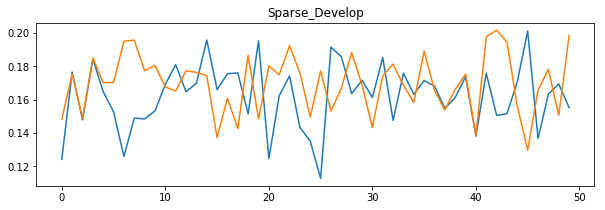

In [421]:
plt.figure(figsize=(10,3))
plt.plot(train_losses, label='Train')
plt.plot(validation_losses, label='Validation')
plt.title(model_name)
plt.show()

# Restoring model

In [11]:
model_name = f'Sparse_Develop'

In [12]:
sorted(os.listdir(DIRS['MODELS']+model_name))

['checkpoint',
 'checkpoint-700.data-00000-of-00001',
 'checkpoint-700.index',
 'checkpoint-700.meta',
 'checkpoint-750.data-00000-of-00001',
 'checkpoint-750.index',
 'checkpoint-750.meta',
 'checkpoint-800.data-00000-of-00001',
 'checkpoint-800.index',
 'checkpoint-800.meta',
 'checkpoint-850.data-00000-of-00001',
 'checkpoint-850.index',
 'checkpoint-850.meta',
 'checkpoint-900.data-00000-of-00001',
 'checkpoint-900.index',
 'checkpoint-900.meta',
 'final.data-00000-of-00001',
 'final.index',
 'final.meta']

In [13]:
tf.reset_default_graph()
#saver = tf.train.import_meta_graph(DIRS['MODELS']+model_name+'/final.meta')
saver = tf.train.import_meta_graph(DIRS['MODELS']+model_name+'/checkpoint-900.meta')
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint(DIRS['MODELS']+model_name))
    restored_variables = {x.name:x.eval(session=sess) for x in tf.global_variables()[:13]}

tf.reset_default_graph()
gru = WaveGRU(input_dimensions, hidden_size, variables_values_dict=restored_variables)

INFO:tensorflow:Restoring parameters from /opt/notebooks/models/Sparse_Develop/checkpoint-900


# Sound generation

In [50]:
os.listdir(DIRS['RAW_DATA']+'cv_corpus_v1/cv-other-train')

['sample-069084.mp3',
 'sample-052026.wav',
 'sample-021278.wav',
 'sample-100405.mp3',
 'sample-084746.wav',
 'sample-031927.mp3',
 'sample-081377.wav',
 'sample-018096.wav',
 'sample-086470.mp3',
 'sample-135826.wav',
 'sample-137030.mp3',
 'sample-082331.wav',
 'sample-086147.wav',
 'sample-109840.mp3',
 'sample-093722.wav',
 'sample-032472.mp3',
 'sample-144959.wav',
 'sample-060054.mp3',
 'sample-134744.mp3',
 'sample-066670.wav',
 'sample-012920.mp3',
 'sample-101368.wav',
 'sample-115965.mp3',
 'sample-082791.wav',
 'sample-117740.wav',
 'sample-137576.wav',
 'sample-042390.mp3',
 'sample-040727.mp3',
 'sample-020920.wav',
 'sample-106453.mp3',
 'sample-114204.mp3',
 'sample-108582.mp3',
 'sample-024396.mp3',
 'sample-041161.mp3',
 'sample-086728.wav',
 'sample-011037.wav',
 'sample-117333.wav',
 'sample-099556.mp3',
 'sample-109228.wav',
 'sample-042075.wav',
 'sample-062833.mp3',
 'sample-055633.mp3',
 'sample-048283.wav',
 'sample-088723.mp3',
 'sample-040334.wav',
 'sample-0